# Setup

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip -q install ultralytics timm
import ultralytics
ultralytics.checks()

import os, cv2, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.cluster import KMeans
from collections import Counter, defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6582.3/8062.4 GB disk)
Device: cuda | torch 2.8.0+cu126


# COCO → YOLO

In [3]:
!pip install roboflow
from roboflow import Roboflow
%pip install ultralytics supervision roboflow

rf = Roboflow(api_key="kb3t7HveaF3ISN0TEWpk")
project = rf.workspace("palm-oil-vj5ii").project("dat-palm-fx-vfhm6")
version = project.version(1)
dataset = version.download("coco")

print("Downloaded dataset to:", dataset.location)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.


Extracting Dataset Version Zip to Dat-Palm-Fx-1 in coco:: 100%|██████████| 4810/4810 [00:01<00:00, 2954.90it/s]


Downloaded dataset to: /kaggle/working/Dat-Palm-Fx-1


In [4]:
import os, json, shutil
from pathlib import Path

OLD_SPLIT = Path("/kaggle/working/palm_byol_ssl/0_yolo_split")
OUT_ROOT  = Path("/kaggle/working/palm/0_yolo_split")

# Roboflow COCO splits usually: train/, valid/, test/
RF_ROOT = Path(dataset.location)

def coco_bbox_to_yolo(bbox_xywh, w, h):
    x, y, bw, bh = bbox_xywh
    cx = x + bw / 2.0
    cy = y + bh / 2.0
    return cx / w, cy / h, bw / w, bh / h

def find_coco_json(split_dir: Path) -> Path:
    """
    Roboflow COCO commonly uses: _annotations.coco.json
    but we search robustly.
    """
    candidates = []
    for p in split_dir.rglob("*.json"):
        name = p.name.lower()
        if "coco" in name or "annotations" in name:
            candidates.append(p)
    if not candidates:
        # fallback: any json
        candidates = list(split_dir.rglob("*.json"))
    if not candidates:
        raise FileNotFoundError(f"No COCO json found under {split_dir}")
    # Prefer _annotations.coco.json if present
    candidates.sort(key=lambda p: (p.name != "_annotations.coco.json", len(str(p))))
    return candidates[0]

def ensure_dirs(out_root: Path):
    for s in ["train", "val", "test"]:
        (out_root / "images" / s).mkdir(parents=True, exist_ok=True)
        (out_root / "labels" / s).mkdir(parents=True, exist_ok=True)

def convert_one_split(split_dir: Path, yolo_split_name: str, cat_id_to_new: dict, out_root: Path):
    coco_json = find_coco_json(split_dir)
    coco = json.loads(coco_json.read_text())

    images = coco.get("images", [])
    anns   = coco.get("annotations", [])
    id_to_img = {im["id"]: im for im in images}

    # group annotations by image_id
    ann_by_img = {}
    for a in anns:
        ann_by_img.setdefault(a["image_id"], []).append(a)

    # convert
    for im in images:
        fn = im.get("file_name", "")
        src_img = split_dir / fn
        if not src_img.exists():
            # Some exports store images in an "images" subfolder
            alt = split_dir / "images" / fn
            if alt.exists():
                src_img = alt
            else:
                continue  # skip missing

        w = im.get("width", None)
        h = im.get("height", None)
        if not w or not h:
            continue

        # copy image
        dst_img = out_root / "images" / yolo_split_name / Path(fn).name
        shutil.copy2(src_img, dst_img)

        # write labels
        label_path = out_root / "labels" / yolo_split_name / (Path(fn).stem + ".txt")
        lines = []
        for a in ann_by_img.get(im["id"], []):
            if a.get("iscrowd", 0) == 1:
                continue
            bbox = a.get("bbox", None)
            if not bbox:
                continue
            cat_id = a.get("category_id", None)
            if cat_id not in cat_id_to_new:
                continue

            cx, cy, bw, bh = coco_bbox_to_yolo(bbox, w, h)

            # clamp
            cx = min(max(cx, 0.0), 1.0)
            cy = min(max(cy, 0.0), 1.0)
            bw = min(max(bw, 0.0), 1.0)
            bh = min(max(bh, 0.0), 1.0)

            cls = cat_id_to_new[cat_id]
            lines.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        label_path.write_text("\n".join(lines) + ("\n" if lines else ""))

def prepare_yolo_from_roboflow_coco(rf_root: Path, out_root: Path):
    # remove old split like your earlier logs
    if OLD_SPLIT.exists():
        shutil.rmtree(OLD_SPLIT, ignore_errors=True)
        print(f"Old YOLO split removed: {OLD_SPLIT}")

    if out_root.exists():
        shutil.rmtree(out_root, ignore_errors=True)

    ensure_dirs(out_root)

    # detect splits
    # Roboflow uses "valid" not "val" — we map it.
    split_map = []
    if (rf_root / "train").exists():
        split_map.append(("train", "train"))
    if (rf_root / "valid").exists():
        split_map.append(("valid", "val"))
    if (rf_root / "val").exists():   # just in case
        split_map.append(("val", "val"))
    if (rf_root / "test").exists():
        split_map.append(("test", "test"))

    if not split_map:
        raise FileNotFoundError(f"No split folders found under {rf_root} (expected train/valid/test).")

    # Build category mapping from the first split’s COCO json
    first_split_dir = rf_root / split_map[0][0]
    first_json = find_coco_json(first_split_dir)
    first_coco = json.loads(first_json.read_text())
    cats = first_coco.get("categories", [])
    cats_sorted = sorted(cats, key=lambda c: c["id"])
    cat_id_to_new = {c["id"]: i for i, c in enumerate(cats_sorted)}
    names = [c["name"] for c in cats_sorted]

    print("Using category mapping (original id -> new index):")
    for k in sorted(cat_id_to_new.keys()):
        print(f"   {k} -> {cat_id_to_new[k]}")

    print("➤ Converting Roboflow COCO splits → YOLO …")
    for rf_name, yolo_name in split_map:
        convert_one_split(rf_root / rf_name, yolo_name, cat_id_to_new, out_root)

    # write data.yaml
    data_yaml = out_root / "data.yaml"
    data_yaml.write_text(
        "path: " + str(out_root) + "\n"
        "train: images/train\n"
        "val: images/val\n"
        + ("test: images/test\n" if (out_root / "images/test").exists() else "")
        + f"nc: {len(names)}\n"
        + "names: " + str(names) + "\n"
    )

    print(f"✓ YOLO split ready at {out_root}")
    print(f"classes (nc): {len(names)} {names}")
    return data_yaml

data_yaml_path = prepare_yolo_from_roboflow_coco(RF_ROOT, OUT_ROOT)
print("\ndata.yaml:", data_yaml_path)

Using category mapping (original id -> new index):
   0 -> 0
   1 -> 1
   2 -> 2
   3 -> 3
➤ Converting Roboflow COCO splits → YOLO …
✓ YOLO split ready at /kaggle/working/palm/0_yolo_split
classes (nc): 4 ['palms-obj', 'abnormal_palm', 'dead_palm', 'healthy_palm']

data.yaml: /kaggle/working/palm/0_yolo_split/data.yaml


# simple visualization

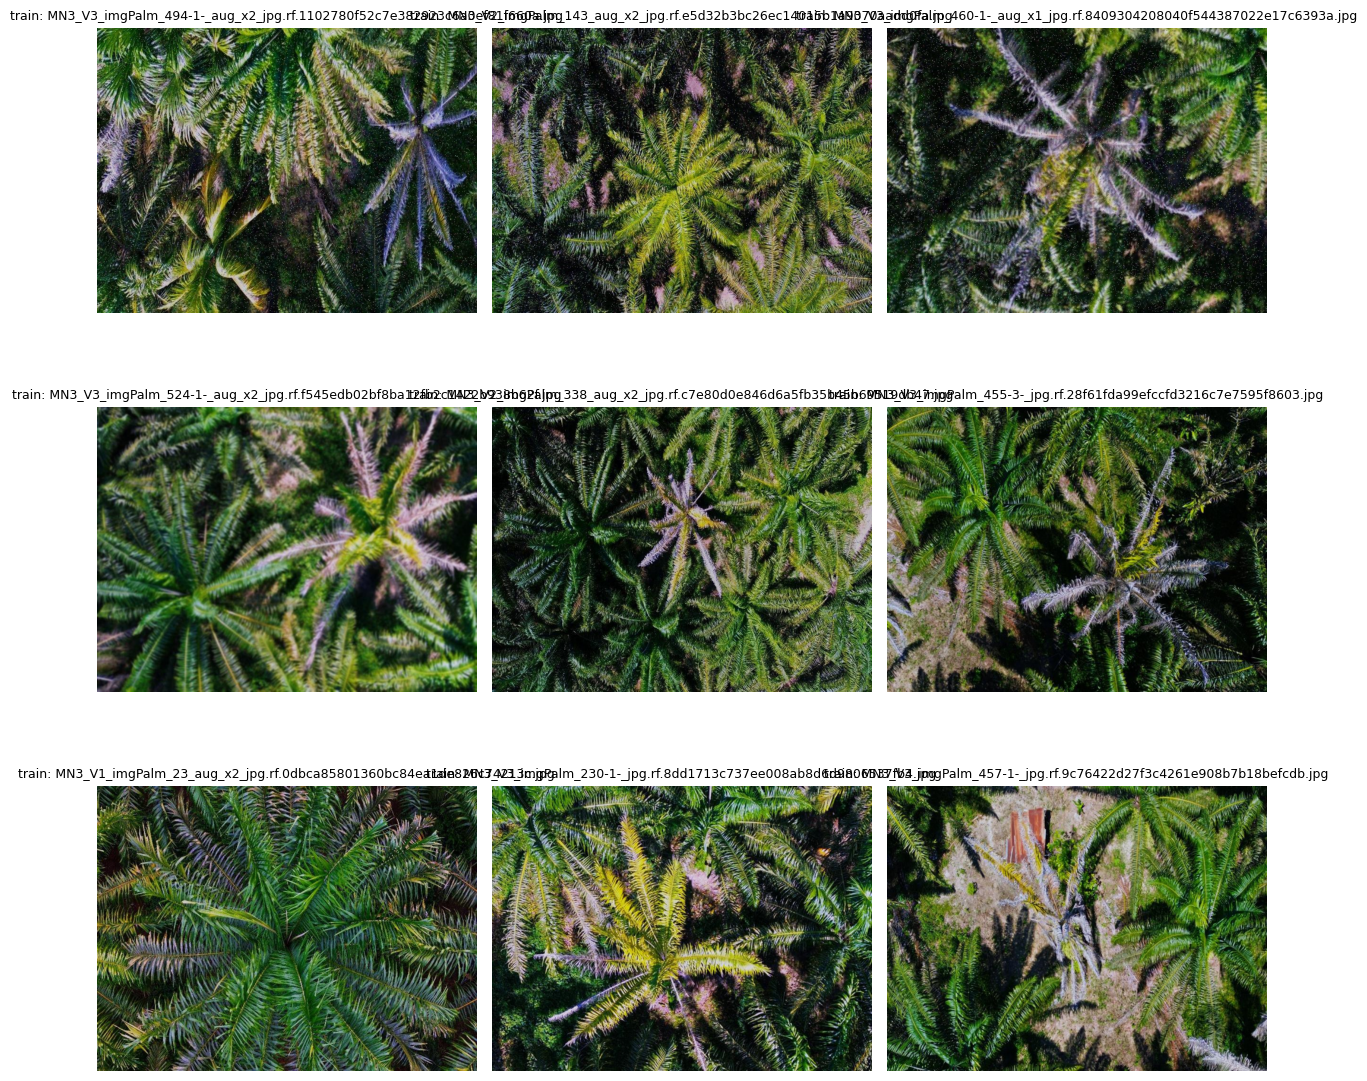

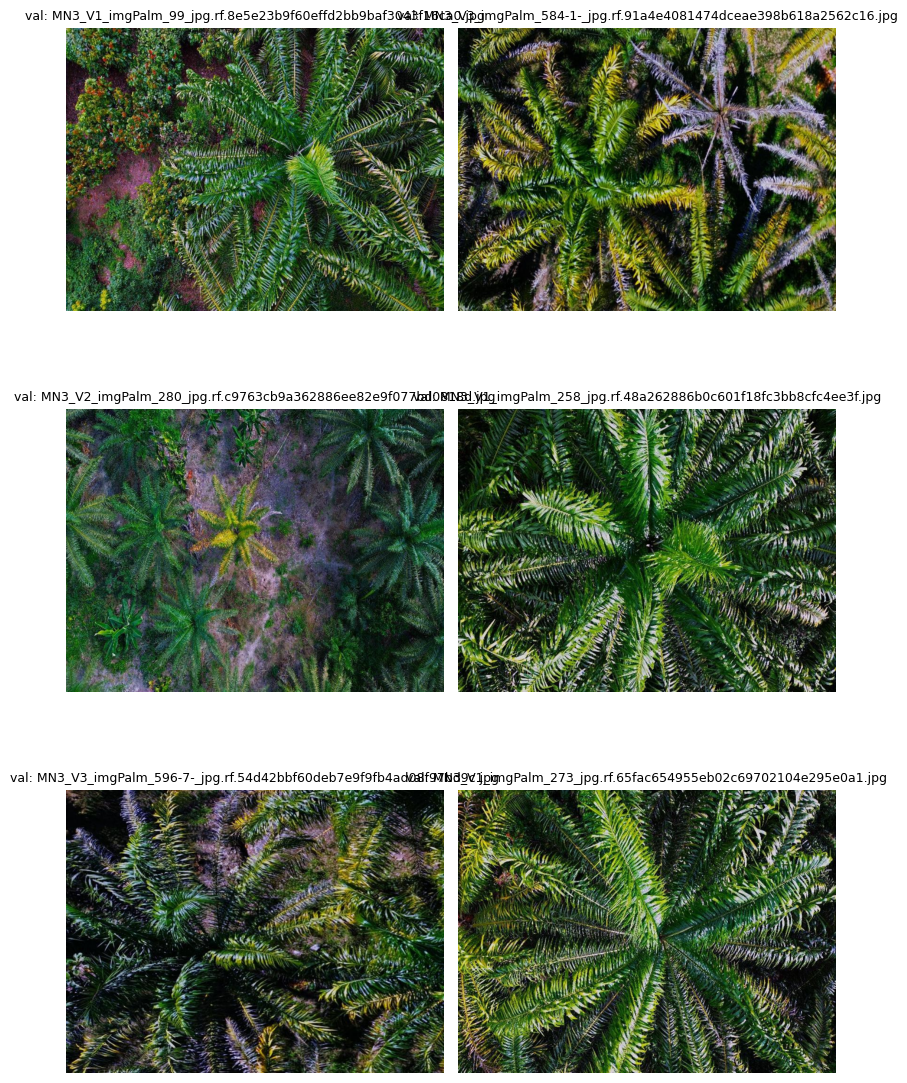

In [5]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Use the YOLO split we created
YOLO_ROOT = Path("/kaggle/working/palm/0_yolo_split")

def show_random_images(split="train", n=9, imgsz=640):
    img_dir = YOLO_ROOT / "images" / split
    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
        imgs += list(img_dir.glob(ext))
    if len(imgs) == 0:
        print(f"No images found in: {img_dir}")
        return

    n = min(n, len(imgs))
    picks = random.sample(imgs, n)

    cols = int(n**0.5)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(cols*4, rows*4))
    for i, p in enumerate(picks, 1):
        im = Image.open(p).convert("RGB")
        im.thumbnail((imgsz, imgsz))
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(f"{split}: {p.name}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show examples
show_random_images("train", n=9)
show_random_images("val", n=6)

In [6]:
from pathlib import Path
import yaml
from collections import Counter

YOLO_ROOT = Path("/kaggle/working/palm/0_yolo_split")
DATA_YAML = YOLO_ROOT / "data.yaml"

#  read classes 
data = yaml.safe_load(DATA_YAML.read_text())
names = data["names"]
nc = data["nc"]

print(f"Classes (nc): {nc}")
for i, n in enumerate(names):
    print(f"  {i}: {n}")

def list_images(split):
    img_dir = YOLO_ROOT / "images" / split
    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
        imgs += list(img_dir.glob(ext))
    return imgs

def count_labels(split):
    lbl_dir = YOLO_ROOT / "labels" / split
    counter = Counter()
    total_boxes = 0
    for txt in lbl_dir.glob("*.txt"):
        lines = txt.read_text().strip().splitlines()
        for line in lines:
            if not line.strip():
                continue
            cls = int(line.split()[0])
            counter[cls] += 1
            total_boxes += 1
    return counter, total_boxes

#  image counts + label counts 
for split in ["train", "val", "test"]:
    imgs = list_images(split)
    if len(imgs) == 0:
        continue

    cls_counts, total_boxes = count_labels(split)

    print(f"\nSplit: {split}")
    print(f"  Images: {len(imgs)}")
    print(f"  Total boxes: {total_boxes}")
    for cls_i in range(nc):
        print(f"  {cls_i} ({names[cls_i]}): {cls_counts.get(cls_i, 0)} boxes")

# overall totals 
overall_imgs = sum(len(list_images(s)) for s in ["train","val","test"])
overall_cls = Counter()
overall_boxes = 0
for s in ["train","val","test"]:
    c, b = count_labels(s)
    overall_cls.update(c)
    overall_boxes += b

print("\nOverall")
print(f"  Total images: {overall_imgs}")
print(f"  Total boxes: {overall_boxes}")
for cls_i in range(nc):
    print(f"  {cls_i} ({names[cls_i]}): {overall_cls.get(cls_i, 0)} boxes")

Classes (nc): 4
  0: palms-obj
  1: abnormal_palm
  2: dead_palm
  3: healthy_palm

Split: train
  Images: 3855
  Total boxes: 9819
  0 (palms-obj): 0 boxes
  1 (abnormal_palm): 2679 boxes
  2 (dead_palm): 2152 boxes
  3 (healthy_palm): 4988 boxes

Split: val
  Images: 200
  Total boxes: 608
  0 (palms-obj): 0 boxes
  1 (abnormal_palm): 128 boxes
  2 (dead_palm): 64 boxes
  3 (healthy_palm): 416 boxes

Split: test
  Images: 747
  Total boxes: 2366
  0 (palms-obj): 0 boxes
  1 (abnormal_palm): 602 boxes
  2 (dead_palm): 245 boxes
  3 (healthy_palm): 1519 boxes

Overall
  Total images: 4802
  Total boxes: 12793
  0 (palms-obj): 0 boxes
  1 (abnormal_palm): 3409 boxes
  2 (dead_palm): 2461 boxes
  3 (healthy_palm): 6923 boxes


# Data AUGMENTATION

In [7]:
%pip -q install albumentations

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os, random
from pathlib import Path
import cv2
import albumentations as A

YOLO_ROOT = Path("/kaggle/working/palm/0_yolo_split")
IMG_DIR   = YOLO_ROOT / "images" / "train"
LBL_DIR   = YOLO_ROOT / "labels" / "train"

MAX_AUG_IMAGES = 200
random.seed(42)

# 4) Albumentations augmentation pipeline
train_transform = A.Compose(
    [
        # Geometric
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5),

        # Photometric
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=50,
            val_shift_limit=30,
            p=0.7,
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.7,
        ),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    ],
    bbox_params=A.BboxParams(
        format="yolo",          # (x_c, y_c, w, h), normalized
        label_fields=["class_labels"],
        min_visibility=0.3,
    ),
)

def read_yolo_label(txt_path: Path):
    bboxes, class_labels = [], []
    if not txt_path.exists():
        return bboxes, class_labels
    lines = txt_path.read_text().strip().splitlines()
    for line in lines:
        if not line.strip():
            continue
        parts = line.split()
        cls = int(parts[0])
        xc, yc, w, h = map(float, parts[1:5])
        bboxes.append([xc, yc, w, h])
        class_labels.append(cls)
    return bboxes, class_labels

def write_yolo_label(txt_path: Path, bboxes, class_labels):
    out_lines = []
    for cls, (xc, yc, w, h) in zip(class_labels, bboxes):
        out_lines.append(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
    txt_path.write_text("\n".join(out_lines) + ("\n" if out_lines else ""))

# collect train images
img_paths = []
for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
    img_paths += list(IMG_DIR.glob(ext))

if len(img_paths) == 0:
    raise FileNotFoundError(f"No training images found in {IMG_DIR}")

random.shuffle(img_paths)

aug_count = 0
attempts = 0
max_attempts = MAX_AUG_IMAGES * 10  # to avoid infinite loops

while aug_count < MAX_AUG_IMAGES and attempts < max_attempts:
    attempts += 1
    src_img_path = random.choice(img_paths)
    src_lbl_path = LBL_DIR / (src_img_path.stem + ".txt")

    bboxes, class_labels = read_yolo_label(src_lbl_path)

    # skip images with no labels (optional, but better for detection)
    if len(bboxes) == 0:
        continue

    img = cv2.imread(str(src_img_path))
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    try:
        transformed = train_transform(image=img, bboxes=bboxes, class_labels=class_labels)
    except Exception:
        continue

    aug_img = transformed["image"]
    aug_bboxes = transformed["bboxes"]
    aug_labels = transformed["class_labels"]

    # skip if all boxes disappeared after augmentation
    if len(aug_bboxes) == 0:
        continue

    # save (as jpg) into the same train folders
    out_name = f"{src_img_path.stem}_aug{aug_count:04d}.jpg"
    out_img_path = IMG_DIR / out_name
    out_lbl_path = LBL_DIR / (Path(out_name).stem + ".txt")

    aug_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(out_img_path), aug_bgr)
    write_yolo_label(out_lbl_path, aug_bboxes, aug_labels)

    aug_count += 1

print(f" Augmentation done. Added {aug_count} augmented TRAIN images into:")
print("   images:", IMG_DIR)
print("   labels:", LBL_DIR)

 Augmentation done. Added 200 augmented TRAIN images into:
   images: /kaggle/working/palm/0_yolo_split/images/train
   labels: /kaggle/working/palm/0_yolo_split/labels/train


# Train YOLOv11s

In [9]:
from ultralytics import YOLO
from pathlib import Path

# Path to your YOLO dataset yaml
DATA_YAML = Path("/kaggle/working/palm/0_yolo_split/data.yaml")

# Train YOLOv11s
model = YOLO("yolo11s.pt")

results = model.train(
    data=str(DATA_YAML),
    epochs=70,
    imgsz=640,
    batch=16,
    project="runs_palm",
    name="yolo11s_70e_aug",
    device=0,
    workers=2,
    exist_ok=True,

    # Early stopping
    patience=7,
)

print("\nTraining complete. Best model saved in:")
best_path = Path(results.save_dir) / "weights" / "best.pt"
print(best_path)


Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/palm/0_yolo_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_70e_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=7, pers

# Evaluate on Validation and Test Sets

In [10]:
import warnings, contextlib, os, sys
from pathlib import Path
from ultralytics import YOLO

# Dataset yaml
yaml_path = Path("/kaggle/working/palm/0_yolo_split/data.yaml")
best_ckpt = Path("runs_palm/yolo11s_70e_aug/weights/best.pt")

assert best_ckpt.exists(), f"Checkpoint not found: {best_ckpt}"

model = YOLO(str(best_ckpt))

@contextlib.contextmanager
def suppress_output():
    """Suppress stdout/stderr (Ultralytics prints a lot)."""
    with open(os.devnull, "w") as devnull:
        old_out, old_err = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_out, old_err

def short_metrics(m):
  
    b = m.box
    return {
        "P": float(b.mp),         # mean precision
        "R": float(b.mr),         # mean recall
        "mAP50": float(b.map50),  # mAP@0.50
        "mAP50-95": float(b.map)  # mAP@0.50:0.95
    }

def print_metrics(title, d):
    print(f"\n{title}")
    print(f"  Precision (P) : {d['P']:.4f}")
    print(f"  Recall (R)    : {d['R']:.4f}")
    print(f"  mAP@0.50      : {d['mAP50']:.4f}")
    print(f"  mAP@0.50:0.95 : {d['mAP50-95']:.4f}")


warnings.filterwarnings("ignore", message="invalid value encountered*")
print("\nEvaluating on validation set (quiet)...")
with suppress_output():
    val_metrics = model.val(data=str(yaml_path), split="val", verbose=False)

print_metrics("Validation Results (summary):", short_metrics(val_metrics))


test_img_dir = Path("/kaggle/working/palm/0_yolo_split/images/test")
if test_img_dir.exists() and any(test_img_dir.glob("*")):
    print("\nEvaluating on test set (quiet)...")
    with suppress_output():
        test_metrics = model.val(data=str(yaml_path), split="test", verbose=False)

    print_metrics("Test Results (summary):", short_metrics(test_metrics))
else:
    print("\nNo test split found (images/test empty/missing). Skipping test evaluation.")



Evaluating on validation set (quiet)...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2411.8±1260.7 MB/s, size: 187.9 KB)
                   all        200        608      0.889      0.927      0.961      0.728
Speed: 1.7ms preprocess, 4.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

Validation Results (summary):
  Precision (P) : 0.8888
  Recall (R)    : 0.9266
  mAP@0.50      : 0.9609
  mAP@0.50:0.95 : 0.7277

Evaluating on test set (quiet)...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2000.0±807.8 MB/s, size: 176.9 KB)
val: New cache created: /kaggle/working/palm/0_yolo_split/labels/test.cache
                   all        747       2366      0.

# Learning Curve 

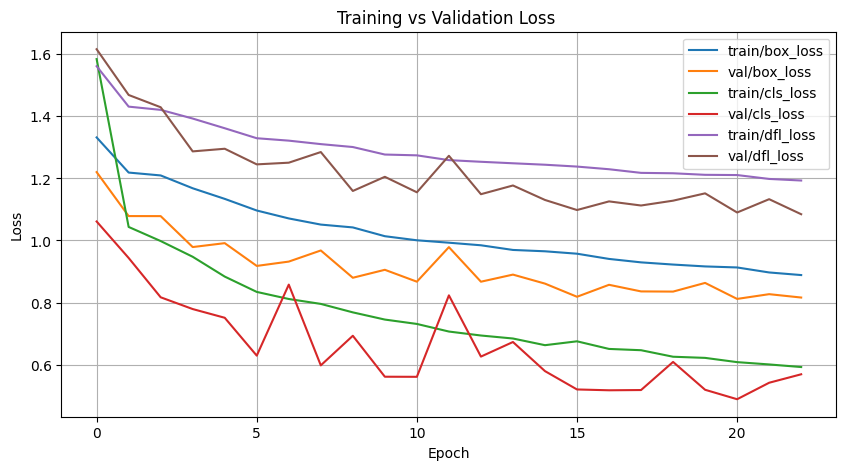

In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

save_dir = Path(results.save_dir)          
df = pd.read_csv(save_dir / "results.csv")
x = df.index

plt.figure(figsize=(10, 5))

# Put TRAIN + VAL losses on the SAME plot
loss_cols = [
    "train/box_loss", "val/box_loss",
    "train/cls_loss", "val/cls_loss",
    "train/dfl_loss", "val/dfl_loss",
]

plotted = False
for c in loss_cols:
    if c in df.columns:
        plt.plot(x, df[c], label=c)
        plotted = True

if not plotted:
    print("No expected loss columns found. Available columns:\n", df.columns.tolist())
else:
    plt.title("Training vs Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()



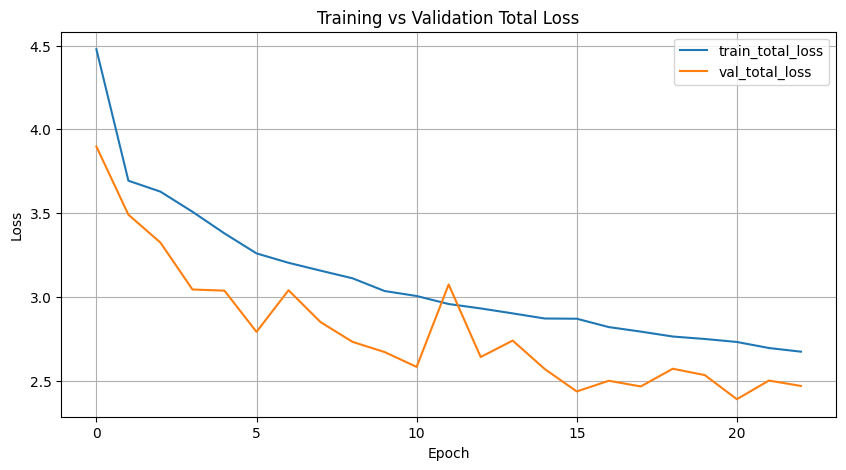

In [12]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

save_dir = Path(results.save_dir)
df = pd.read_csv(save_dir / "results.csv")
x = df.index  # epochs

plt.figure(figsize=(10, 5))

# Total loss = box + cls + dfl (common for YOLO detection)
train_total = 0
val_total = 0
found = False

for tcol, vcol in [("train/box_loss","val/box_loss"),
                   ("train/cls_loss","val/cls_loss"),
                   ("train/dfl_loss","val/dfl_loss")]:
    if tcol in df.columns and vcol in df.columns:
        train_total = train_total + df[tcol]
        val_total   = val_total + df[vcol]
        found = True

if not found:
    print("Loss columns not found. Available columns:\n", df.columns.tolist())
else:
    plt.plot(x, train_total, label="train_total_loss")
    plt.plot(x, val_total,   label="val_total_loss")
    plt.title("Training vs Validation Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


# Pick random test images and run inference


Running inference for visualization...


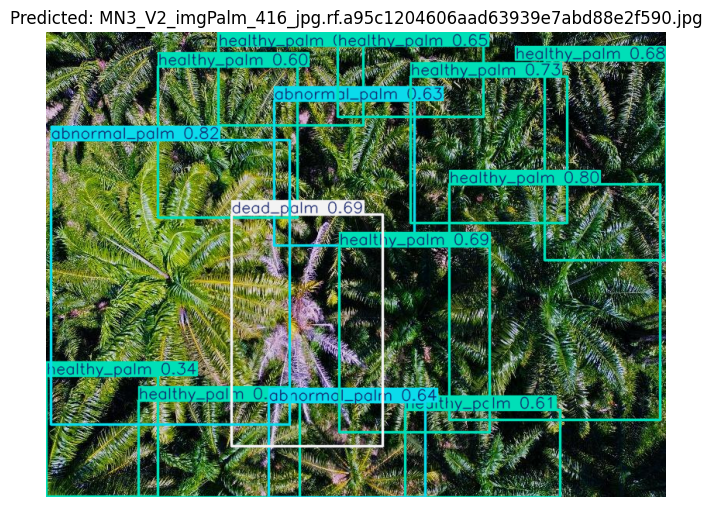

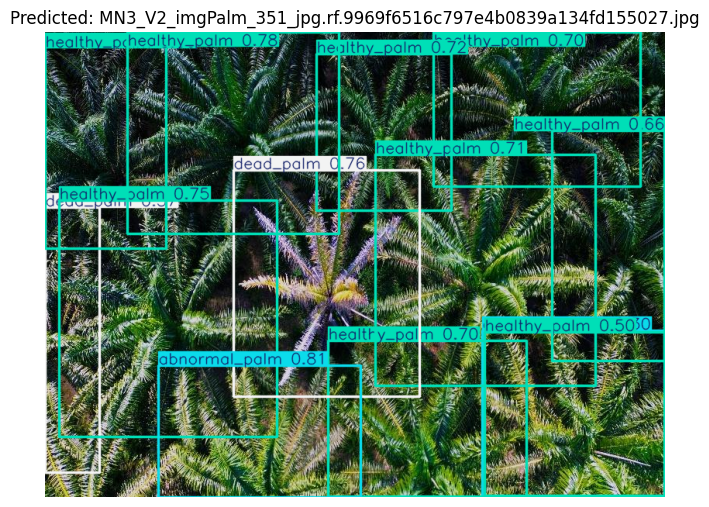

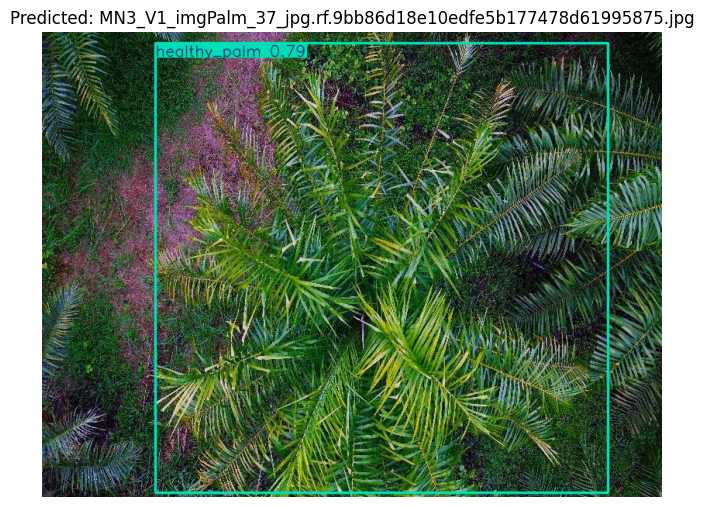

In [13]:
import random
from pathlib import Path
import yaml
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# paths
yaml_path = Path("/kaggle/working/palm/0_yolo_split/data.yaml")
best_ckpt = Path("runs_palm/yolo11s_70e_aug/weights/best.pt")
if not best_ckpt.exists():
    runs_root = Path("runs_palm")
    print(f"Checkpoint not found: {best_ckpt}")
    if runs_root.exists():
        print("\nAvailable runs in runs_palm/:")
        for p in sorted(runs_root.glob("*")):
            if p.is_dir():
                print(" -", p.as_posix())
    raise FileNotFoundError(best_ckpt)

model = YOLO(str(best_ckpt))

# Load data.yaml
data_cfg = yaml.safe_load(yaml_path.read_text())
root = Path(data_cfg.get("path", ""))  
val_entry = data_cfg["val"]


val_paths = []
val_entry_path = Path(val_entry)

if str(val_entry).endswith(".txt"):
    txt_path = val_entry_path if val_entry_path.is_absolute() else (root / val_entry_path)
    if not txt_path.exists():
        raise FileNotFoundError(f"val list file not found: {txt_path}")
    val_paths = [Path(line.strip()) for line in txt_path.read_text().splitlines() if line.strip()]
else:
    val_dir = val_entry_path if val_entry_path.is_absolute() else (root / val_entry_path)
    if not val_dir.exists():
        raise FileNotFoundError(f"val directory not found: {val_dir}")
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"):
        val_paths += list(val_dir.glob(ext))

if len(val_paths) == 0:
    raise FileNotFoundError("No validation images found from the 'val' split in data.yaml")

# Pick random images and run inference
print("\nRunning inference for visualization...")
sample_imgs = random.sample(val_paths, k=min(3, len(val_paths)))

for img_path in sample_imgs:
    results = model(str(img_path), verbose=False)
    annotated = results[0].plot()  # BGR image (numpy)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predicted: {img_path.name}")
    plt.show()
